In [181]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error


matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False

### Lag Feature (지연 피쳐)

In [182]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download('spy', start='1900-04-01', end='2021-04-01')
data_ = data[["Close"]].copy()
data_.columns = [["Close"]]

spy = data_[["Close"]].copy()

spy["lag_1"] = data_.shift(1)
spy["Close_rag_100"] = data_.shift(100)
spy["Close_rag_200"] = data_.shift(200)
spy["Close_rag_300"] = data_.shift(300)

[*********************100%***********************]  1 of 1 completed


In [183]:
spy = spy.dropna()
spy.reset_index(inplace=True)
spy.head()

,Date,Close,lag_1,Close_rag_100,Close_rag_200,Close_rag_300
0,1994-04-07 00:00:00+00:00,45.031250,44.81250,46.59375,44.21875,43.93750
1,1994-04-08 00:00:00+00:00,44.687500,45.03125,46.56250,44.81250,44.25000
2,1994-04-11 00:00:00+00:00,44.875000,44.68750,46.78125,44.78125,44.34375
3,1994-04-12 00:00:00+00:00,44.812500,44.87500,46.53125,45.28125,44.81250
4,1994-04-13 00:00:00+00:00,44.578125,44.81250,46.40625,45.06250,45.00000


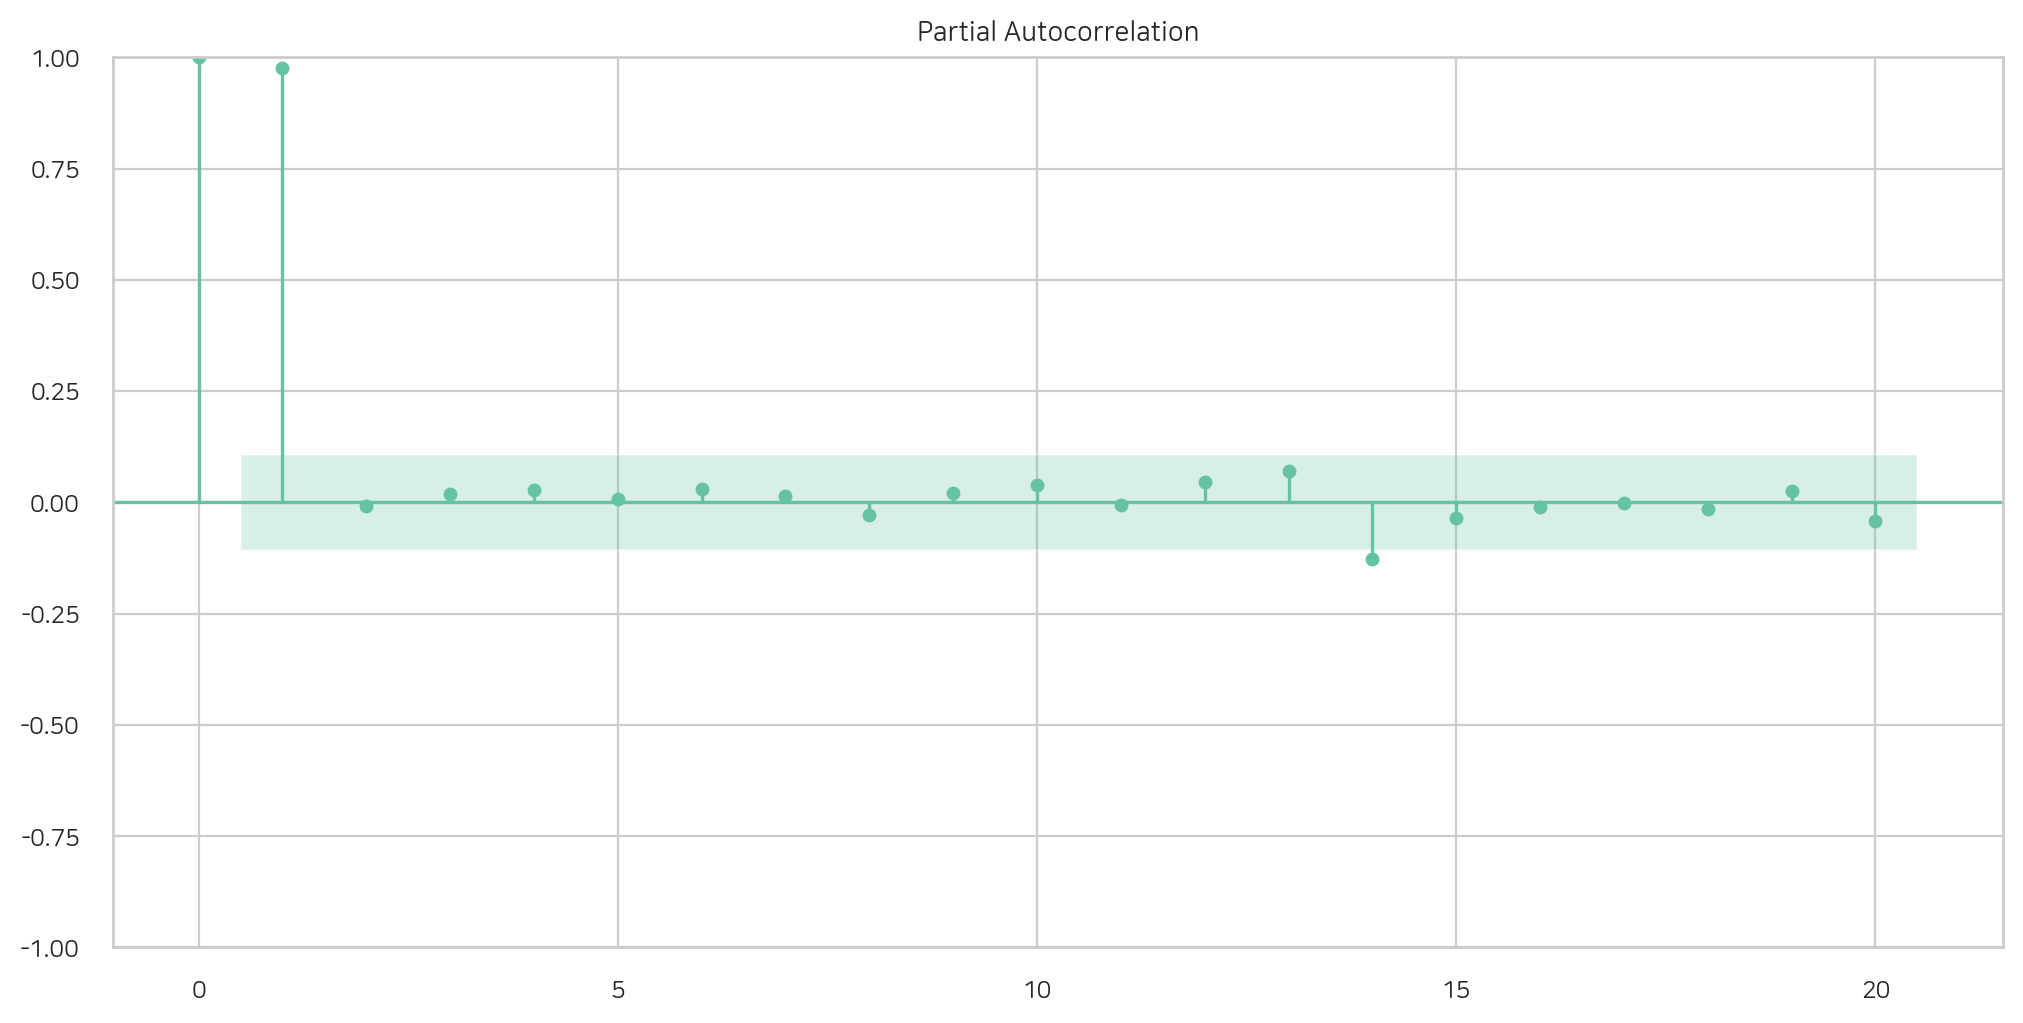

In [184]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

snp_20 = spy.iloc[0:-1:20] # 주말빼고 약 한달에 20일정도씩

fig, ax = plt.subplots(1,1, figsize=(10,5))

plot_pacf(snp_20['Close'], lags=20, ax=ax);

In [185]:
new_snp = snp_20[["Close"]].copy()
new_snp["lag_1"] = new_snp["Close"].shift(1)
new_snp["lag_10"] = new_snp["Close"].shift(10)
new_snp["lag_19"] = new_snp["Close"].shift(19)

In [186]:
new_snp.columns = ['Close', 'lag_1','lag_10','lag_19']
new_snp.head()

,Close,lag_1,lag_10,lag_19
0,45.031250,NaN,NaN,NaN
20,44.750000,45.031250,NaN,NaN
40,46.218750,44.750000,NaN,NaN
60,44.796875,46.218750,NaN,NaN
80,46.187500,44.796875,NaN,NaN


/tmp/ipykernel_103160/2323520518.py:17: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


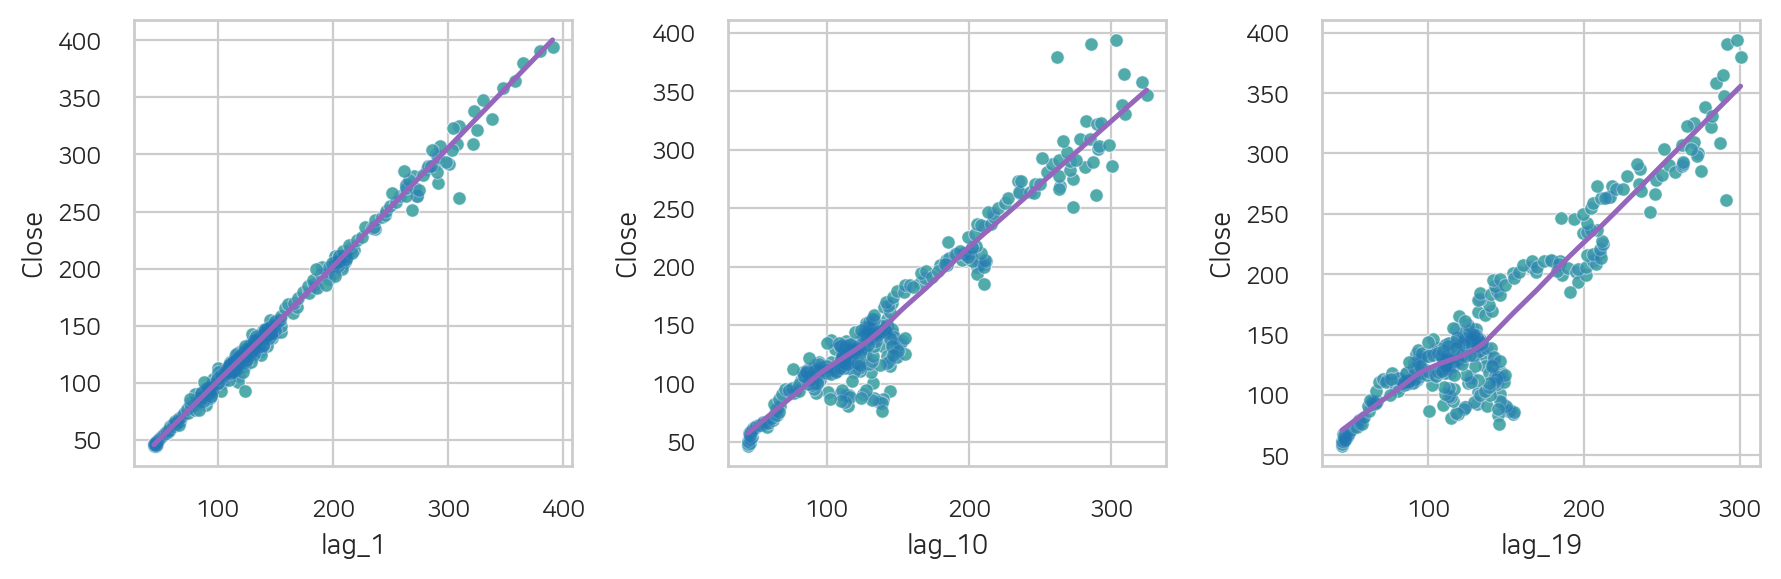

In [187]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
lags = [1,10,19]

for i in range(len(lags)):
    sns.scatterplot(data=new_snp,
                    x="lag_" + str(lags[i]),
                    y="Close",
                    ax=ax[i])
    
    sns.regplot(data=new_snp,
                    x="lag_" + str(lags[i]),
                    y="Close",
                    scatter_kws={"color": "tab:blue", "alpha": 0.3},
                    color = "tab:purple",
                    lowess=True,
                    ax=ax[i],);
fig.tight_layout()

In [188]:
new_snp.dropna(inplace=True)

In [189]:
X = new_snp.drop(columns=["Close"])
y = new_snp["Close"]

In [190]:
from sklearn.model_selection import train_test_split

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)

In [192]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(301, 3)
(20, 3)
(301,)
(20,)


In [193]:
# 1. lag 피쳐의 모델 (lag_1, lag_10, lag_19)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y, test_size=20, shuffle=False)

model_f = LinearRegression()
model_f.fit(X_train, y_train)
y_pred_2 = pd.Series(model_f.predict(X_train_f), index=y_train_f.index)
y_fore_2 = pd.Series(model_f.predict(X_test_f), index=y_test_f.index)

### 이동평균선

In [194]:
# 2. 이동 평균선 + 피쳐 (lag_1, moving_mean)
new_snp["moving_mean"] = new_snp["Close"].rolling(window=5,center=True).mean()
new_snp.dropna(axis=0, inplace=True)

X = new_snp.drop(columns=["Close"])
y = new_snp["Close"]

X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X[["lag_1","moving_mean"]], y, test_size=20, shuffle=False)

model_mm = LinearRegression()
model_mm.fit(X_train_mm, y_train_mm)
y_pred_3 = pd.Series(model_mm.predict(X_train_mm), index=y_train_mm.index)
y_fore_3 = pd.Series(model_mm.predict(X_test_mm), index=y_test_mm.index)

In [195]:
# 3. 이동 평균선만으로 (moving_mean)
X_train_mm_2, X_test_mm_2, y_train_mm_2, y_test_mm_2 = train_test_split(X[["moving_mean"]], y, test_size=20, shuffle=False)

model_mm = LinearRegression()
model_mm.fit(X_train_mm_2, y_train_mm_2)
y_pred_4 = pd.Series(model_mm.predict(X_train_mm_2), index=y_train_mm_2.index)
y_fore_4 = pd.Series(model_mm.predict(X_test_mm_2), index=y_test_mm_2.index)

In [196]:
snp_20.columns = [i[0] for i in snp_20.columns]

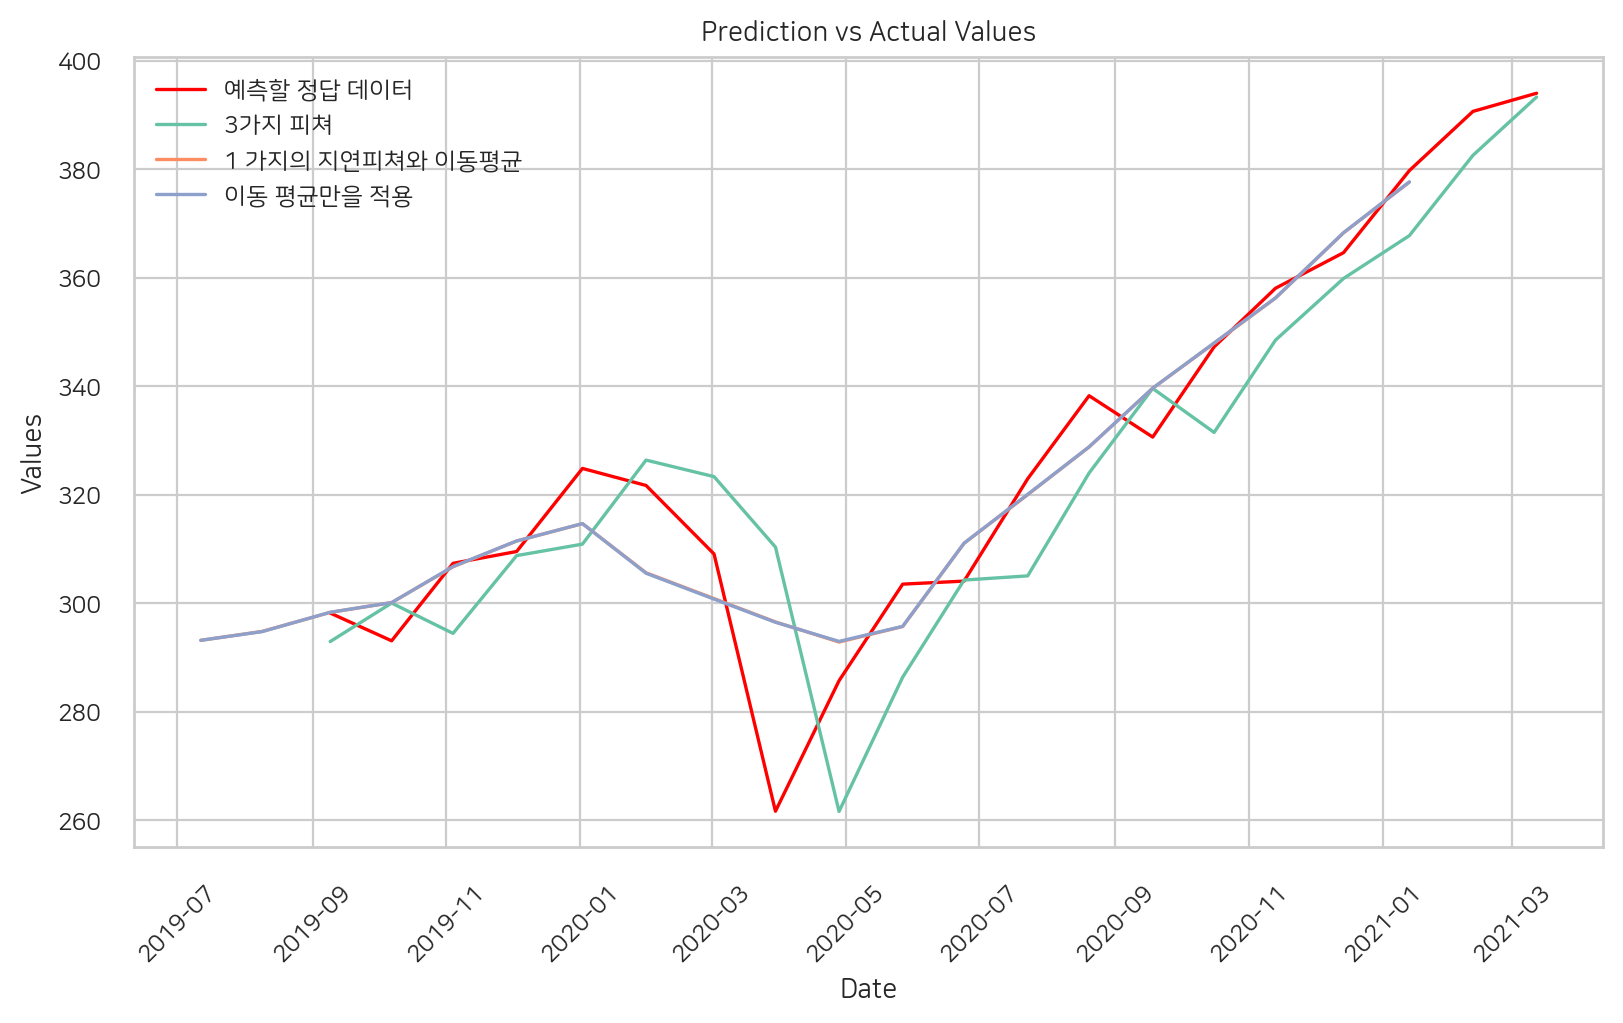

In [197]:
fig, ax = plt.subplots(1,1, figsize=(8,5))


sns.lineplot(x=snp_20["Date"].loc[y_test.index],
             y=y_test,
             color="red",
             label="예측할 정답 데이터",)

sns.lineplot(x=snp_20["Date"].loc[y_fore_2.index],
             y=y_fore_2,
             label="3가지 피쳐",)

sns.lineplot(x=snp_20["Date"].loc[y_fore_3.index],
             y=y_fore_3,
             label="1 가지의 지연피쳐와 이동평균",)

sns.lineplot(x=snp_20["Date"].loc[y_fore_4.index],
             y=y_fore_4,
             label="이동 평균만을 적용",)

ax.set(xlabel='Date', ylabel='Values', title = "Prediction vs Actual Values")
plt.xticks(rotation=45);

In [198]:
print("""\
3종의 시간지연 MSE : {:0.2f}
이동평균  MSE : {:0.2f}
이동평균과 1종의 시간 지연 MSE : {:0.2f}\
""".format(
mean_squared_error(y_test_f,y_fore_2),
mean_squared_error(y_test_mm_2,y_fore_4),
mean_squared_error(y_test_mm,y_fore_3),
))

3종의 시간지연 MSE : 254.56
이동평균  MSE : 106.55
이동평균과 1종의 시간 지연 MSE : 106.52


In [199]:
spy_close = spy[["Date","Close"]].copy()
spy_close.columns=["Date","Close"]

In [200]:
spy_close.columns

Index(['Date', 'Close'], dtype='object')

In [201]:
spy_close

,Date,Close
0,1994-04-07 00:00:00+00:00,45.031250
1,1994-04-08 00:00:00+00:00,44.687500
2,1994-04-11 00:00:00+00:00,44.875000
3,1994-04-12 00:00:00+00:00,44.812500
4,1994-04-13 00:00:00+00:00,44.578125
...,...,...
6789,2021-03-25 00:00:00+00:00,389.700012
6790,2021-03-26 00:00:00+00:00,395.980011
6791,2021-03-29 00:00:00+00:00,395.779999
6792,2021-03-30 00:00:00+00:00,394.730011


In [202]:
spy_close['Date'] = pd.to_datetime(spy_close['Date'])
spy_close['Date_num'] = (spy_close['Date'] - spy_close['Date'].min()).dt.days

### regplot(회귀선)

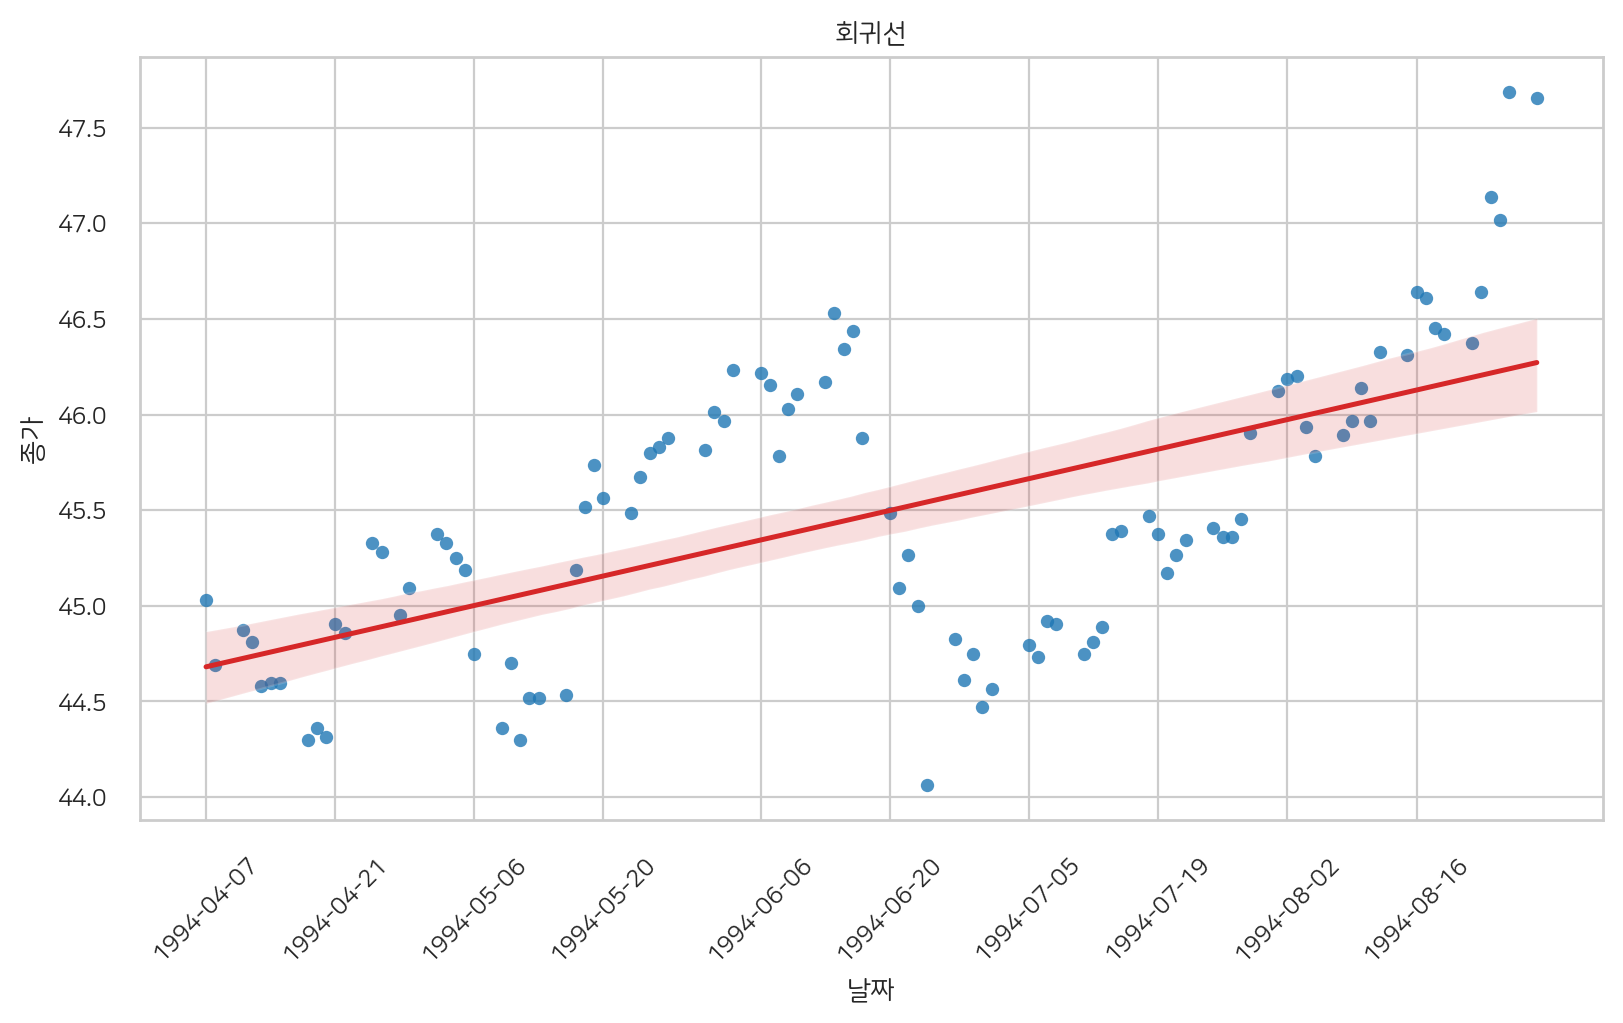

In [203]:
plt.figure(figsize=(8, 5))

sns.regplot(x='Date_num', y='Close',
            data=spy_close[:100], marker='o',
            scatter_kws={'color': 'tab:blue'},
            line_kws={'color': 'tab:red'})

plt.title('회귀선')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.xticks(ticks=spy_close['Date_num'][:100][::10],
           labels=spy_close['Date'][:100][::10].dt.strftime('%Y-%m-%d'), rotation=45);